In [1]:
import glob
import os
import pickle
import pathlib
import string
import nltk

from os import listdir

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
%matplotlib inline

from tqdm import tqdm
import pandas as pd

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Input, Dropout ,Embedding
#from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.layers.merge import add
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow import keras


In [ ]:
print(tf.__version__) 

2.8.0


In [ ]:
print(np.__version__)

1.21.6


In [2]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [3]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 237 kB 5.3 MB/s 


In [4]:
import tensorflow_model_optimization as tfmot

In [ ]:
print(tfmot.__version__)

0.7.2


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
token = '/content/drive/MyDrive/MasterCode/Flickr8k_text/Flickr8k.token.txt'

In [7]:
captions = open(token, 'r').read().strip().split('\n')

Complete Dataset Tokens are saved within "captions"

In [8]:
len(captions)

40460

In [9]:
type(captions)

list

## Creating a dictionary containing all the captions of the images

In [10]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [11]:
d['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
images = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/'


All images from complete data set is stored in "img"

In [13]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [14]:
img[:5]

['/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/378170167_9b5119d918.jpg',
 '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3728015645_b43a60258b.jpg',
 '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/387830531_e89c192b92.jpg',
 '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/386470686_1ae9242878.jpg',
 '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3728695560_00ec1ca492.jpg']

In [15]:
train_images_file = '/content/drive/MyDrive/MasterCode/Flickr8k_text/Flickr_8k.trainImages.txt'

In [16]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [17]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

Path for each training images are stored within "train_img"

In [18]:
# Getting the training images from all the images
train_img = split_data(train_images)
len(train_img)

6000

In [19]:
train_img[0]

'/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/378170167_9b5119d918.jpg'

In [20]:
val_images_file = '/content/drive/MyDrive/MasterCode/Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

Path for each Validation images path are stored within "val_img"

In [21]:
# Getting the validation images from all the images
val_img = split_data(val_images)
len(val_img)

1000

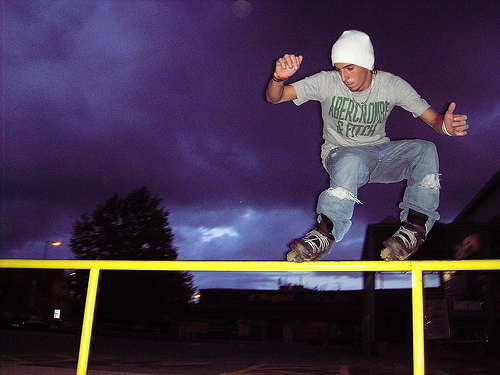

In [22]:
Image.open(val_img[0])

In [23]:
test_images_file = '/content/drive/MyDrive/MasterCode/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

Path for each Testing images path are stored within "Test_img"

In [24]:
# Getting the testing images from all the images
test_img = split_data(test_images)
len(test_img)

1000

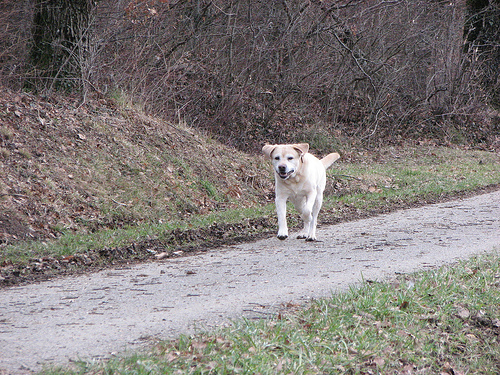

In [25]:
Image.open(train_img[0])

We will feed these images to InceptionV3 to get the encoded images. Hence we need to preprocess the images as the authors of InceptionV3 did. The last layer of InceptionV3 is the softmax classifier(FC layer with 1000 hidden neurons) which returns the probability of a class. This layer should be removed so as to get a feature representation of an image. We will use the last Dense layer(2048 hidden neurons) after popping the classifier layer. Hence the shape of the encoded image will be (1, 2048)

In [26]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [27]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


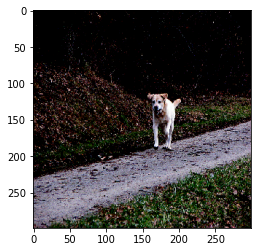

In [28]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [29]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


In [30]:
new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [31]:
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [32]:
tryi = model_new.predict(preprocess(train_img[0]))

In [33]:
tryi.shape

(1, 2048)

In [34]:
temp_enc1 = np.reshape(tryi, tryi.shape[1])

In [35]:
temp_enc1

array([0.08570674, 0.90871775, 0.472896  , ..., 0.04665372, 1.3265964 ,
       0.57544625], dtype=float32)

In [36]:
temp_enc1.shape

(2048,)

In [37]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

Train encode Images stored at "encoding_train"

In [ ]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

  0%|          | 12/6000 [00:05<42:28,  2.35it/s]


KeyboardInterrupt: ignored

In [ ]:
with open("/content/drive/MyDrive/MasterCode/encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle) 

Train encode Images stored at "encoding_train" within file "encoded_images_inceptionV3.p"

In [38]:
encoding_train = pickle.load(open('/content/drive/MyDrive/MasterCode/encoded_images_inceptionV3.p', 'rb'))

In [39]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

Test encode Images stored at "encoding_test" within file "encoded_images_test_inceptionV3.p"

In [ ]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

  4%|▎         | 36/1000 [00:12<05:30,  2.92it/s]


KeyboardInterrupt: ignored

In [ ]:
with open("/content/drive/MyDrive/MasterCode/encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle) 

In [40]:
encoding_test = pickle.load(open('/content/drive/MyDrive/MasterCode/encoded_images_test_inceptionV3.p', 'rb'))

In [41]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [ ]:
encoding_val = {}
for img in tqdm(val_img):
    encoding_val[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [07:23<00:00,  2.26it/s]


In [ ]:
with open("/content/drive/MyDrive/MasterCode/encoded_images_val_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_val, encoded_pickle) 

In [42]:
encoding_val = pickle.load(open('/content/drive/MyDrive/MasterCode/encoded_images_val_inceptionV3.p', 'rb'))

In [43]:
encoding_val[val_img[0][len(images):]].shape

(2048,)

Train Dictornary of every image with multiple captions "train_d"

In [44]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [45]:
len(train_d)

6000

In [46]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

Validation Dictornary of every image with multiple captions "val_d"

In [47]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [48]:
len(val_d)

1000

In [49]:
val_d[images+'2090545563_a4e66ec76b.jpg']

['the boy laying face down on a skateboard is being pushed along the ground by another boy .',
 'Two girls play on a skateboard in a courtyard .',
 'Two people play on a long skateboard .',
 'Two small children in red shirts playing on a skateboard .',
 'two young children on a skateboard going across a sidewalk']

Testing Dictornary of every image with multiple captions "test_d"

In [50]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [51]:
len(test_d)

1000

Calculating the unique words in the vocabulary within only trained dataset

In [52]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [53]:
words = [i.split() for i in caps]

In [54]:
unique = []
for i in words:
    unique.extend(i)

In [55]:
unique = list(set(unique))

Unique Vocabluary of complete Training captions

In [ ]:
with open("/content/drive/MyDrive/MasterCode/unique.p", "wb") as pickle_d:
     pickle.dump(unique, pickle_d) 

In [56]:
unique = pickle.load(open('/content/drive/MyDrive/MasterCode/unique.p', 'rb'))

In [57]:
len(unique)

8256

Mapping the unique words to indices and vice-versa

In [58]:
word2idx = {val:index for index, val in enumerate(unique)}

In [59]:
word2idx['<start>']

7014

In [60]:
idx2word = {index:val for index, val in enumerate(unique)}

In [61]:
idx2word[5553]

'dinner'

Calculating the maximum length among all the captions

In [62]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [63]:
len(unique), max_len

(8256, 40)

In [64]:
vocab_size = len(unique)

In [65]:
vocab_size

8256

Adding <start> and <end> to all the captions to indicate the starting and ending of a sentence. This will be used while we predict the caption of an image

In [ ]:
f = open('/content/drive/MyDrive/MasterCode/Flickr8k_text/flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [ ]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

"df" is the training dataset from the file

In [66]:
df = pd.read_csv('/content/drive/MyDrive/MasterCode/Flickr8k_text/flickr8k_training_dataset.txt', delimiter='\t')

In [67]:
len(df)

30000

In [ ]:
f_val = open('/content/drive/MyDrive/MasterCode/Flickr8k_text/flickr8k_val_dataset.txt', 'w')
f_val.write("image_id\tcaptions\n")

18

In [ ]:
for key, val in val_d.items():
    for i in val:
        f_val.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f_val.close()

In [68]:
df_val = pd.read_csv('/content/drive/MyDrive/MasterCode/Flickr8k_text/flickr8k_val_dataset.txt', delimiter='\t')

In [69]:
len(df_val)

5000

"c" is dictory for all trainig captions per image

In [70]:
c = [i for i in df['captions']]
len(c)

30000

"imgs" is dictory for all trainig  training images

In [71]:
imgs = [i for i in df['image_id']]

In [72]:
a = c[-1]
a, imgs[-1]

('<start> The little girl is playing with a toy in a public fountain . <end>',
 '1115565519_d976d4b1f1.jpg')

In [73]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 7014
The => 5013
little => 2361
girl => 8083
is => 4996
playing => 7497
with => 7399
a => 737
toy => 3788
in => 6162
a => 737
public => 1547
fountain => 3151
. => 5665
<end> => 4129


In [74]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [75]:
samples_per_epoch

383454

In [76]:
caps_val = []
for key, val in val_d.items():
    for i in val:
        caps_val.append('<start> ' + i + ' <end>')

In [77]:
samples_per_epoch_val = 0
for ca_val in caps_val:
    samples_per_epoch_val += len(ca_val.split())-1

In [78]:
samples_per_epoch_val

64445

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
CAPTIONS_FILE = '/content/drive/MyDrive/capstone_project/input/captions.txt'

IMAGE_PATH = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset'

In [ ]:
# Function defination to read the content of "caption.txt"

def load_doc(filename):
    #your code here
    file = open(filename)
    text = file.read()
    file.close()
    return text

#Import the dataset and read the text file into a seperate variable
doc = load_doc(CAPTIONS_FILE)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [ ]:
def get_img_ids_path_and_captions(text):
    img_name_id=[]
    captions=[]
    image_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        img_name_id.append(im_id)
        captions.append(im_cap)
        image_paths.append(IMAGE_PATH+'/'+im_id)
    return img_name_id,image_paths, captions

In [ ]:
#store all the image id here
#store all the image path here
#store all the captions here
all_img_id, all_img_vector, annotations = get_img_ids_path_and_captions(doc)
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head(10)

ID  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                                Path  \
0  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   
1  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   
2  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   
3  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   
4  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   
5  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   
6  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   
7  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   
8  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   
9  /content/drive/MyDrive/MasterCode/Flickr8k_Dat...   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [ ]:
# Fucntion to extract the all words within the data frame that is shared using split function
def voc_extract(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out

In [ ]:
# Check the datatype of each member of Dataframe and number of entries should be same
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        40455 non-null  object
 1   Path      40455 non-null  object
 2   Captions  40455 non-null  object
dtypes: object(3)
memory usage: 948.3+ KB


In [ ]:
#Create the vocabulary & the counter for the captions

vocabulary= voc_extract(df,'Captions')#write your code here

# Extract the number of Words occurance
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

In [ ]:
#Visualise the top 30 occuring words in the captions
most_occur = val_count.most_common(30)
print(most_occur)

[('a', 40271), ('.', 34212), ('A', 21481), ('in', 18961), ('the', 15328), ('on', 10729), ('is', 9345), ('and', 8850), ('dog', 7982), ('with', 7760), ('man', 6828), ('of', 6712), ('Two', 3962), ('white', 3875), ('black', 3696), ('are', 3503), ('boy', 3442), ('woman', 3227), ('girl', 3217), (',', 3210), ('to', 3173), ('wearing', 3061), ('The', 2920), ('at', 2904), ('water', 2774), ('red', 2660), ('brown', 2475), ('people', 2442), ('young', 2431), ('."', 2365)]


In [ ]:
df_word = pd.DataFrame.from_dict(val_count, orient = 'index')
df_word = df_word.sort_values(by = [0], ascending=False).reset_index()
df_word = df_word.rename(columns={'index':'word', 0:'count'})

df_word.head()

word  count
0    a  40271
1    .  34212
2    A  21481
3   in  18961
4  the  15328

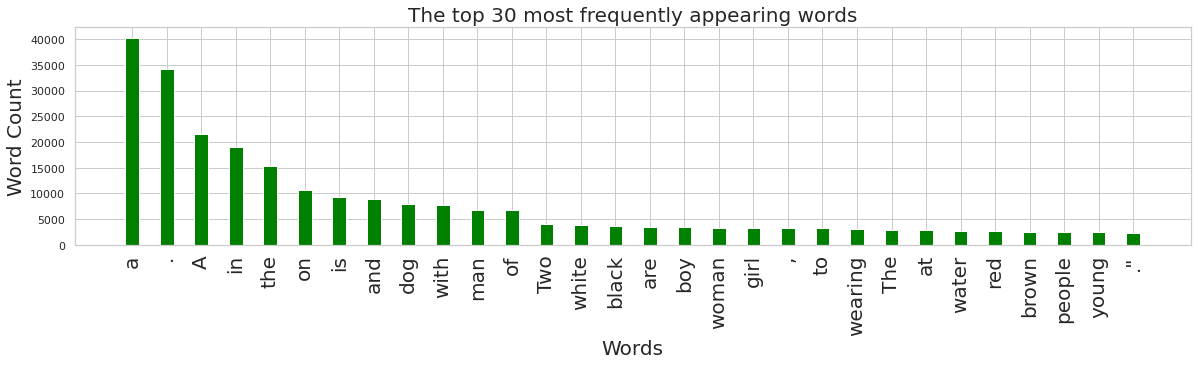

In [ ]:
#Visualise the top 30 occuring words in the captions
def plthist(index,words,count, title="The top 30 most frequently appearing words"):
    plt.figure(figsize=(20,4))
    plt.bar(words,count,color='green', width =0.4)
    plt.xlabel("Words",  fontsize=20) 
    plt.ylabel("Word Count",rotation=90,fontsize=20) 
   # plt.yticks(fontsize=20)
    plt.xticks(index,words,rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
words = list(df_word[:30].word)

count =list(df_word['count'][:30])
plthist(list(range(0,30)),words,count)

Text(0.5, 1.0, 'Plot of count vs words')

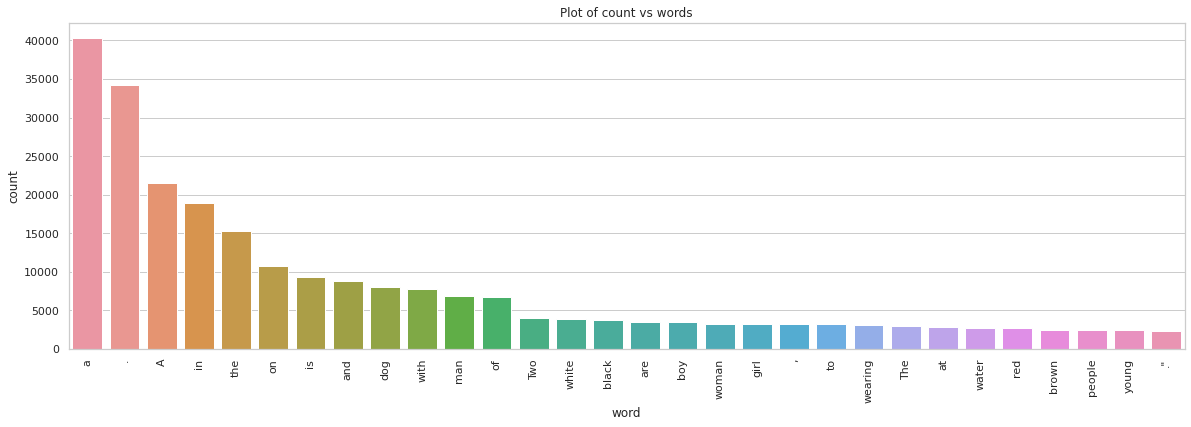

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,6))
sns.barplot(x="word",y="count",data=df_word[:30])
plt.xticks(rotation='vertical')
plt.title('Plot of count vs words')


Text(0.5, 1.0, 'Plot of count vs words')

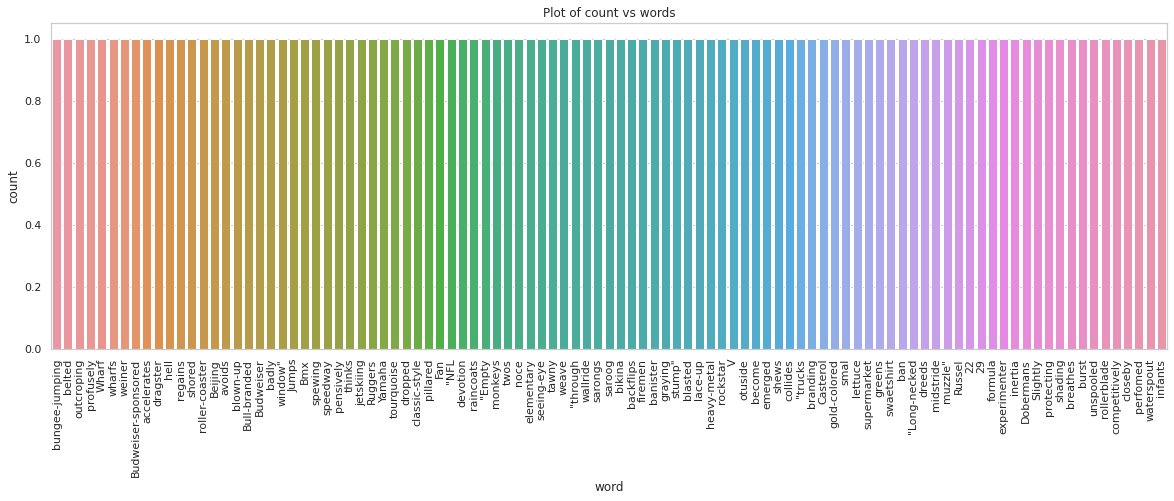

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,6))
sns.barplot(x="word",y="count",data=df_word[-100:-1])
plt.xticks(rotation='vertical')
plt.title('Plot of count vs words')

In [ ]:
data=df_word[-100:-1]

In [ ]:
print(data)

                word  count
9762  bungee-jumping      1
9763          belted      1
9764      outcroping      1
9765       profusely      1
9766           Wharf      1
...              ...    ...
9856   competitively      1
9857         closeby      1
9858        perfomed      1
9859      waterspout      1
9860         infants      1

[99 rows x 2 columns]


In [ ]:
# Plot the images across multiple captions

def plot_image_captions(Pathlist,captionsList,fig,count=2,npix=299,nimg=2):
        image_load = load_img(Path,target_size=(npix,npix,3))
        ax = fig.add_subplot(nimg,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        
        count +=1
        ax = fig.add_subplot(nimg,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)

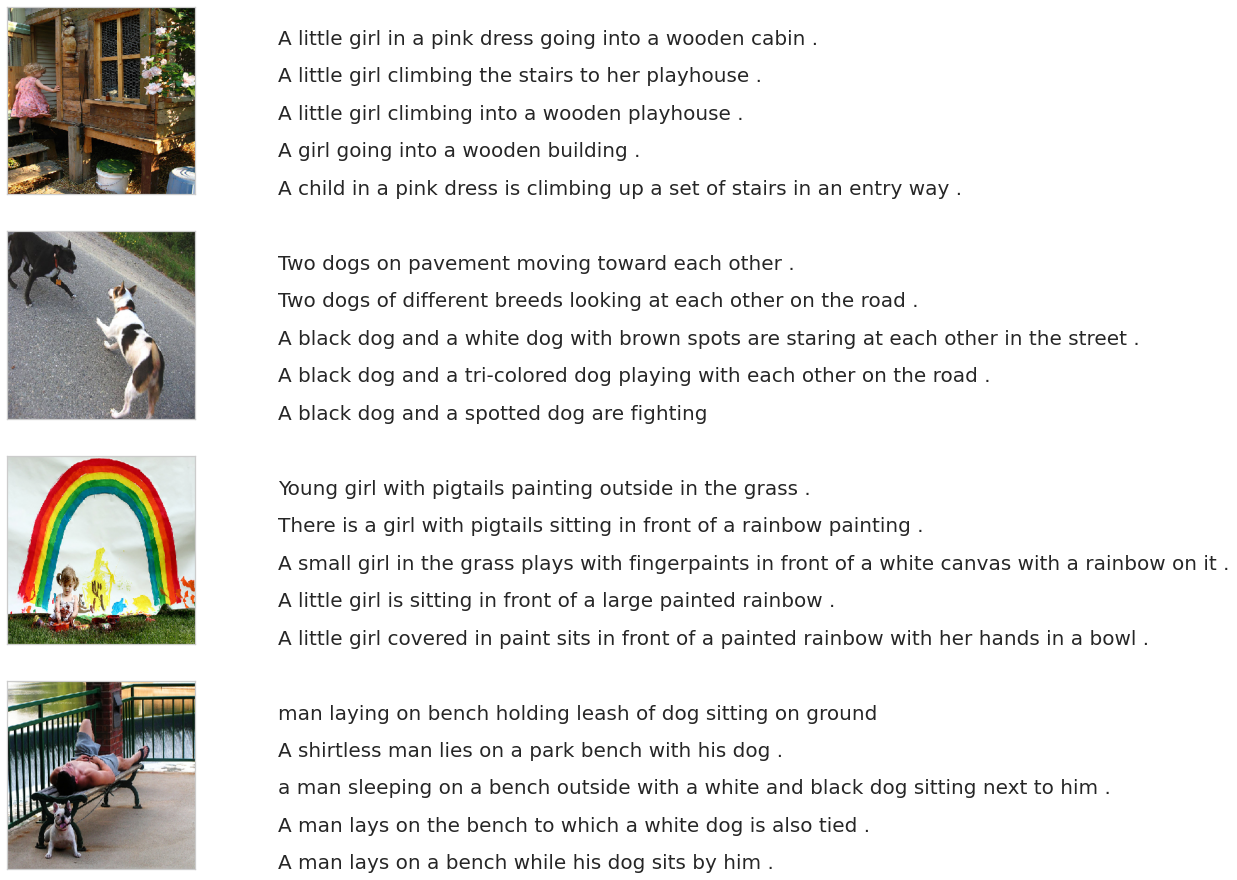

In [ ]:
# Images 
fig = plt.figure(figsize=(10,20))
count = 1
    
for Path in df[:20].Path.unique():
    captions = list(df["Captions"].loc[df.Path== Path].values)
    plot_image_captions(Path,captions,fig,count,299,5)
    count +=2
plt.show()

In [ ]:
from collections import Counter

In [ ]:
uni_filenames= np.unique(df.ID.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:", Counter(Counter(df.ID.values).values()))

The number of unique file names : 8091
The distribution of the number of captions for each image: Counter({5: 8091})


Validation dataset word to text and text word creation

In [81]:
words_val = [i.split() for i in caps_val]

In [82]:
unique_val = []
for i in words_val:
    unique_val.extend(i)

In [83]:
unique_val = list(set(unique_val))

In [ ]:
with open("/content/drive/MyDrive/MasterCode/unique_val.p", "wb") as pickle_d_val:
     pickle.dump(unique_val, pickle_d_val) 

In [84]:
unique_val = pickle.load(open('/content/drive/MyDrive/MasterCode/unique_val.p', 'rb'))

In [85]:
len(unique_val)

3523

In [86]:
word2idx_val = {val:index for index, val in enumerate(unique_val)}

In [87]:
word2idx_val['<start>']

2670

In [88]:
idx2word_val = {index:val for index, val in enumerate(unique_val)}

In [89]:
idx2word_val[2670]

'<start>'

In [90]:
max_len_val = 0
for c in caps_val:
    c = c.split()
    if len(c) > max_len_val:
        max_len_val = len(c)
max_len_val

35

In [91]:
len(unique_val), max_len_val

(3523, 35)

In [92]:
vocab_size_val = len(unique_val)

In [93]:
vocab_size_val

3523

## Generator 

We will use the encoding of an image and use a start word to predict the next word.
After that, we will again use the same image and use the predicted word 
to predict the next word.
So, the image will be used at every iteration for the entire caption. 
This is how we will generate the caption for an image. Hence, we need to create 
a custom generator for that.

The CS231n lecture by Andrej Karpathy explains this concept very clearly and beautifully.
Link for the lecture:- https://youtu.be/cO0a0QYmFm8?t=32m25s

In [94]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('/content/drive/MyDrive/MasterCode/Flickr8k_text/flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [95]:
def validation_data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('/content/drive/MyDrive/MasterCode/Flickr8k_text/flickr8k_val_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_val[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

## Let's create the model

In [ ]:
#embedding_size = 300

## **NAGARAJ Layered Model Creation **

In [96]:
inputshape = 2048
maxlength= max_len
inputs1 = Input(shape=(inputshape,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence model
inputs2 = Input(shape=(maxlength,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

final_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
#final_model.compile(loss='categorical_crossentropy', optimizer='adam')
final_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])



In [97]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      2113536     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

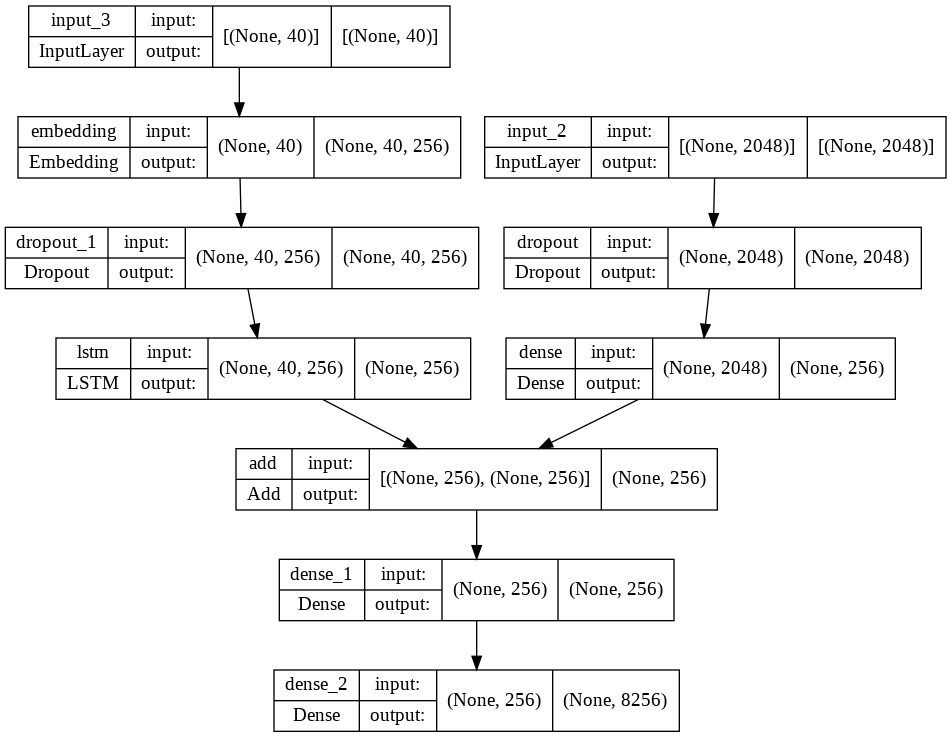

In [98]:
plot_model(final_model, to_file='model.png', show_shapes=True)

Input dimension is 4096 since we will feed it the encoded version of the image.

In [ ]:
#image_model = Sequential([
 #       Dense(embedding_size, input_shape=(2048,), activation='relu'),
  #      RepeatVector(max_len)
   # ])

Since we are going to predict the next word using the previous words(length of previous words changes with every iteration over the caption), we have to set return_sequences = True.

In [ ]:
#caption_model = Sequential([
     #   Embedding(vocab_size, embedding_size, input_length=max_len),
     #   LSTM(256, return_sequences=True),
     #   TimeDistributed(Dense(300))
   # ])

Merging the models and creating a softmax classifier

In [ ]:
#final_model = Sequential([
 #       merge([image_model, caption_model], mode='concat', concat_axis=1),
  #      Bidirectional(LSTM(256, return_sequences=False)),
   #     Dense(vocab_size),
    #    Activation('softmax')
    #])

In [ ]:
#model = Merge([image_model, caption_model], mode='concat', concat_axis=1)

In [ ]:
#final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [ ]:
#final_model.summary()

In [99]:
steps = samples_per_epoch

In [100]:
steps_val = samples_per_epoch_val

In [102]:
num_epochs = 30
modelname = 'Base-InceptionV3-baseline-LSTM-Accuracy'
FOLDERPATH = '/content/drive/MyDrive/H5_model'
WEIGHT_FOLDERPATH = '/content/drive/MyDrive/Weights'
SAVE_MODEL_FOLDERPATH = '/content/drive/MyDrive/saved_model/my_model'

# performing data argumentation by training image generator
dataAugmentaion = ImageDataGenerator(rotation_range = 30, zoom_range = 0.20, 
fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
width_shift_range = 0.1, height_shift_range = 0.1)

# training the model
model.fit_generator(dataAugmentaion.flow(trainX, trainY, batch_size = 32),
 validation_data = (testX, testY), steps_per_epoch = len(trainX) // 32,
 epochs = 10)

In [ ]:
#final_model.fit_generator(data_generator(batch_size=128),steps_per_epoch = steps//128,epochs=1,verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


2995/2995 - 816s - loss: 3.0081 - accuracy: 0.4007 - 816s/epoch - 273ms/step


In [103]:
for i in range(1,num_epochs+1):
  print('Epoch' + str(i))
  final_model.fit_generator(data_generator(batch_size=128),steps_per_epoch = steps//128,epochs=1,verbose=2)
  if i%5 == 0:
    final_model.save(FOLDERPATH+modelname+'_ep__accuracy' + str(i) + '.h5')
    final_model.save(SAVE_MODEL_FOLDERPATH+modelname + str(i))
    #final_model.save_weights(WEIGHT_FOLDERPATH+modelname + str(i))
    

Epoch1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2995/2995 - 676s - loss: 3.7138 - accuracy: 0.3434 - 676s/epoch - 226ms/step
Epoch2
2995/2995 - 654s - loss: 3.0044 - accuracy: 0.4016 - 654s/epoch - 218ms/step
Epoch3
2995/2995 - 626s - loss: 2.7501 - accuracy: 0.4211 - 626s/epoch - 209ms/step
Epoch4
2995/2995 - 617s - loss: 2.5876 - accuracy: 0.4335 - 617s/epoch - 206ms/step
Epoch5
2995/2995 - 619s - loss: 2.4681 - accuracy: 0.4428 - 619s/epoch - 207ms/step


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy5/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy5/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch6
2995/2995 - 625s - loss: 2.3773 - accuracy: 0.4505 - 625s/epoch - 209ms/step
Epoch7
2995/2995 - 625s - loss: 2.3032 - accuracy: 0.4576 - 625s/epoch - 209ms/step
Epoch8
2995/2995 - 623s - loss: 2.2419 - accuracy: 0.4639 - 623s/epoch - 208ms/step
Epoch9
2995/2995 - 624s - loss: 2.1949 - accuracy: 0.4690 - 624s/epoch - 208ms/step
Epoch10
2995/2995 - 624s - loss: 2.1512 - accuracy: 0.4751 - 624s/epoch - 208ms/step


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy10/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy10/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch11
2995/2995 - 625s - loss: 2.1158 - accuracy: 0.4796 - 625s/epoch - 209ms/step
Epoch12
2995/2995 - 629s - loss: 2.0875 - accuracy: 0.4832 - 629s/epoch - 210ms/step
Epoch13
2995/2995 - 627s - loss: 2.0582 - accuracy: 0.4872 - 627s/epoch - 209ms/step
Epoch14
2995/2995 - 629s - loss: 2.0333 - accuracy: 0.4921 - 629s/epoch - 210ms/step
Epoch15
2995/2995 - 605s - loss: 2.0141 - accuracy: 0.4943 - 605s/epoch - 202ms/step


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy15/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy15/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch16
2995/2995 - 597s - loss: 1.9946 - accuracy: 0.4974 - 597s/epoch - 199ms/step
Epoch17
2995/2995 - 596s - loss: 1.9785 - accuracy: 0.4988 - 596s/epoch - 199ms/step
Epoch18
2995/2995 - 596s - loss: 1.9632 - accuracy: 0.5019 - 596s/epoch - 199ms/step
Epoch19
2995/2995 - 591s - loss: 1.9493 - accuracy: 0.5045 - 591s/epoch - 197ms/step
Epoch20
2995/2995 - 590s - loss: 1.9369 - accuracy: 0.5057 - 590s/epoch - 197ms/step


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy20/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy20/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch21
2995/2995 - 587s - loss: 1.9241 - accuracy: 0.5081 - 587s/epoch - 196ms/step
Epoch22
2995/2995 - 589s - loss: 1.9156 - accuracy: 0.5095 - 589s/epoch - 197ms/step
Epoch23
2995/2995 - 583s - loss: 1.9053 - accuracy: 0.5106 - 583s/epoch - 195ms/step
Epoch24
2995/2995 - 607s - loss: 1.8976 - accuracy: 0.5112 - 607s/epoch - 203ms/step
Epoch25
2995/2995 - 622s - loss: 1.8894 - accuracy: 0.5138 - 622s/epoch - 208ms/step


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy25/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy25/assets
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch26
2995/2995 - 623s - loss: 1.8822 - accuracy: 0.5155 - 623s/epoch - 208ms/step
Epoch27
2995/2995 - 621s - loss: 1.8758 - accuracy: 0.5154 - 621s/epoch - 207ms/step
Epoch28
2995/2995 - 621s - loss: 1.8719 - accuracy: 0.5168 - 621s/epoch - 207ms/step
Epoch29
2995/2995 - 621s - loss: 1.8659 - accuracy: 0.5178 - 621s/epoch - 207ms/step
Epoch30
2995/2995 - 658s - loss: 1.8583 - accuracy: 0.5187 - 658s/epoch - 220ms/step


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM-Accuracy30/assets


In [ ]:

final_model_learningrate = final_model

In [ ]:
final_model.optimizer.lr = 1e-4
final_model.fit_generator(data_generator(batch_size=128),steps_per_epoch = steps//128,epochs=1,verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


2995/2995 - 618s - loss: 1.8342 - 618s/epoch - 206ms/step


In [ ]:
num_epochs = 30
for i in range(21,num_epochs+1):
  print('Epoch' + str(i))
  final_model.fit_generator(data_generator(batch_size=128),steps_per_epoch = steps//128,epochs=1,verbose=2)
  if i%5 == 0:
    final_model.save(FOLDERPATH+modelname+'_ep_' + str(i) + '.h5')
    final_model.save(SAVE_MODEL_FOLDERPATH+modelname + str(i))
    final_model.save_weights(WEIGHT_FOLDERPATH+modelname + str(i))

Epoch21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


2995/2995 - 614s - loss: 1.7999 - 614s/epoch - 205ms/step
Epoch22
2995/2995 - 622s - loss: 1.7839 - 622s/epoch - 208ms/step
Epoch23
2995/2995 - 612s - loss: 1.7711 - 612s/epoch - 204ms/step
Epoch24
2995/2995 - 654s - loss: 1.7615 - 654s/epoch - 218ms/step
Epoch25
2995/2995 - 647s - loss: 1.7522 - 647s/epoch - 216ms/step


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM25/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM25/assets


Epoch26


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


2995/2995 - 635s - loss: 1.7459 - 635s/epoch - 212ms/step
Epoch27
2995/2995 - 671s - loss: 1.7404 - 671s/epoch - 224ms/step
Epoch28
2995/2995 - 644s - loss: 1.7326 - 644s/epoch - 215ms/step
Epoch29
2995/2995 - 624s - loss: 1.7278 - 624s/epoch - 208ms/step
Epoch30
2995/2995 - 624s - loss: 1.7201 - 624s/epoch - 208ms/step


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM30/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM30/assets


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/my_modelBase-InceptionV3-baseline-LSTM30')

# Check its architecture
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      2113536     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
final_model = new_model

In [ ]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      2113536     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
#final_model.save_weights('/content/drive/MyDrive/MasterCode/time_inceptionV3_3.15_loss.h5')

In [ ]:
# load model
#savedModel = final_model.load_weights('/content/drive/MyDrive/MasterCode/time_inceptionV3_3.15_loss.h5')

In [ ]:
#savedModel

In [ ]:
# load model
#savedModel = tf.keras.models.load_model('/content/drive/MyDrive/BasicModel.h5')
savedModel.summary()

In [ ]:
#final_model.save_weights('time_inceptionV3_7_loss_3.2604.h5')

In [ ]:
#final_model.load_weights('time_inceptionV3_7_loss_3.2604.h5')

## Predict funtion

In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoding_test[image[len(images):]]
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

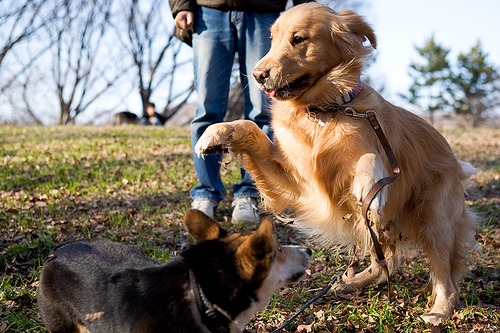

In [ ]:
try_image = test_img[0]
Image.open(try_image)

In [ ]:
print ('Normal Max search:', predict_captions(try_image)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image, beam_index=7))

Normal Max search: A dog is running through a field .
Beam Search, k=3: Two dogs run through the grass .
Beam Search, k=5: A brown dog and a small white dog .
Beam Search, k=7: A brown dog and a small white dog .


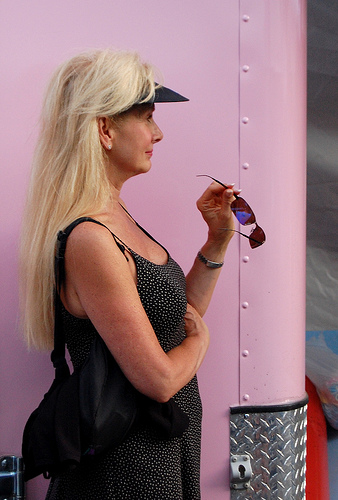

In [ ]:
try_image2 = test_img[7]
Image.open(try_image2)

In [ ]:
print ('Normal Max search:', predict_captions(try_image2)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image2, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image2, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image2, beam_index=7))

Normal Max search: A man and a woman are sitting on a bench .
Beam Search, k=3: A group of people sit on a bench in front of a Christmas tree .
Beam Search, k=5: A group of people sit on a bench in front of a Christmas tree .
Beam Search, k=7: A group of people wait for a train .


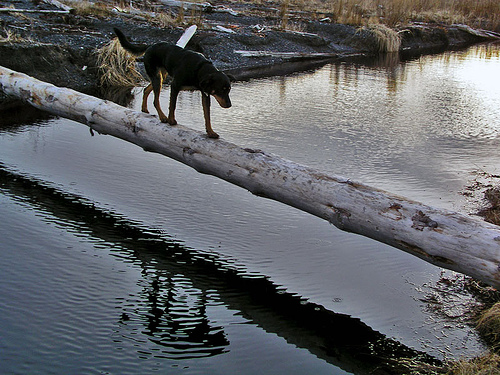

In [ ]:
try_image3 = test_img[851]
Image.open(try_image3)

In [ ]:
print ('Normal Max search:', predict_captions(try_image3)) 
print ('Beam Search, k=3:', beam_search_predictions(try_image3, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image3, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image3, beam_index=7))

Normal Max search: A dog is running through the water .
Beam Search, k=3: A black and white dog swimming in a lake .
Beam Search, k=5: A black and white dog swimming in murky water .
Beam Search, k=7: A black and white dog swimming in murky water .


Normal Max search: A man in a red uniform rides a bike down a dirt hill .
Beam Search, k=3: A man on a dirt bike .
Beam Search, k=5: A man on a dirt bike .
Beam Search, k=7: A man on a dirt bike .


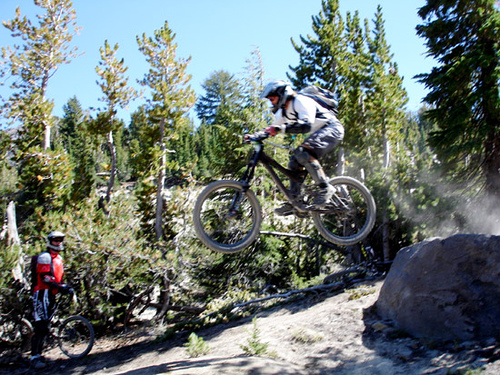

In [ ]:
try_image4 = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/136552115_6dc3e7231c.jpg'
print ('Normal Max search:', predict_captions(try_image4))
print ('Beam Search, k=3:', beam_search_predictions(try_image4, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(try_image4, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(try_image4, beam_index=7))
Image.open(try_image4)

Normal Max search: A white dog is running on the grass .
Beam Search, k=3: A white dog is running in a field .
Beam Search, k=5: A white dog is running in a field .
Beam Search, k=7: A white dog holds a stick in its mouth .


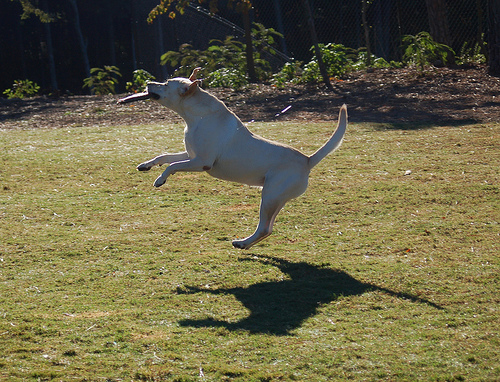

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/1674612291_7154c5ab61.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A dog runs through the snow .
Beam Search, k=3: A brown and white dog is running in the snow .
Beam Search, k=5: A brown and white dog running in the snow .
Beam Search, k=7: A brown and white dog jumps in the snow .


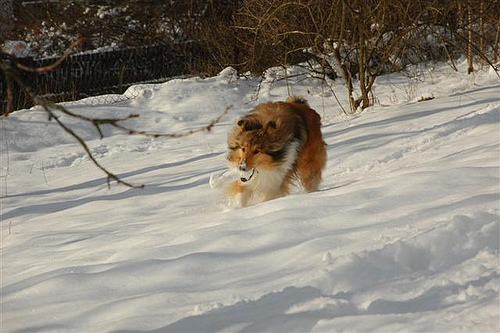

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/384577800_fc325af410.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A surfer is riding a wave .
Beam Search, k=3: A surfer rides a wave .
Beam Search, k=5: A waterskier crashes over a wave .
Beam Search, k=7: A waterskier crashes over a wave .


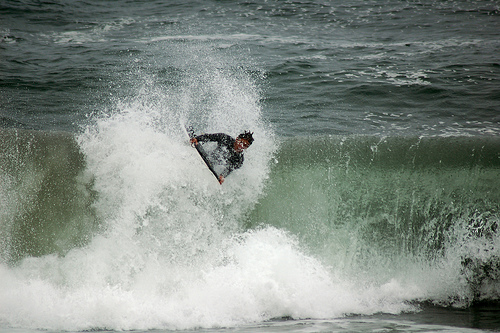

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3631986552_944ea208fc.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A young boy in a red jacket is standing in the snow .
Beam Search, k=3: A little boy in a red jacket is standing in the snow .
Beam Search, k=5: A little boy in a red jacket is standing in the snow .
Beam Search, k=7: A little boy in a red jacket sliding down a snow slope .


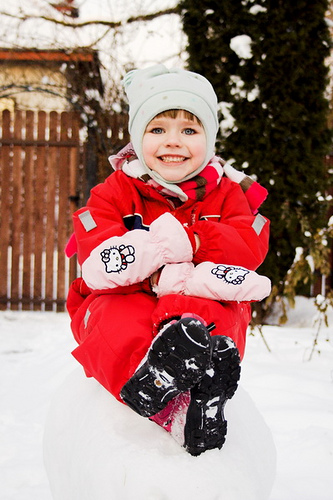

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3320032226_63390d74a6.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A man in a red shirt and helmet rides a bike on a dirt path .
Beam Search, k=3: A man on a dirt bike .
Beam Search, k=5: A man on a dirt bike .
Beam Search, k=7: A man on a bmx bike .


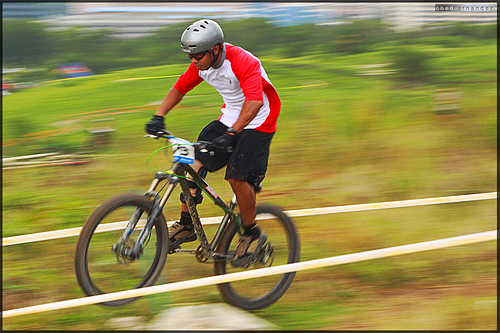

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3316725440_9ccd9b5417.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A boy is skateboarding down a handrail .
Beam Search, k=3: A boy wearing Rollerblades slides down a handrail .
Beam Search, k=5: A boy wearing Rollerblades slides down a handrail .
Beam Search, k=7: A teenage boy grinding a rail on his skateboard .


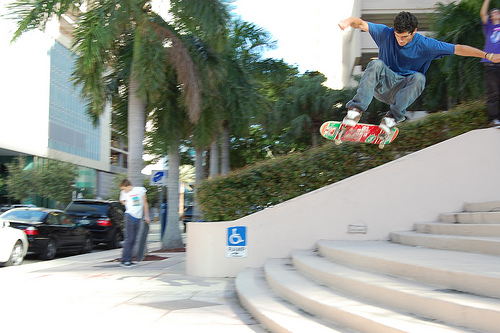

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2306674172_dc07c7f847.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Normal Max search: A dog jumps over a hurdle .
Beam Search, k=3: A black and white dog jumps over a hurdle .
Beam Search, k=5: A black and white dog jumps over a hurdle .
Beam Search, k=7: A black and white dog jumps over a hurdle .


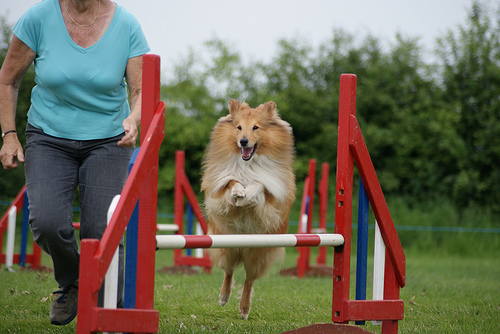

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2542662402_d781dd7f7c.jpg'
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3530843182_35af2c821c.jpg
Normal Max search: A man in a black shirt and sunglasses is smiling .
Beam Search, k=3: A closeup of a man in a blue shirt .
Beam Search, k=5: A closeup of a man and a woman pose for a picture .
Beam Search, k=7: A closeup of a man and a woman pose for a picture .


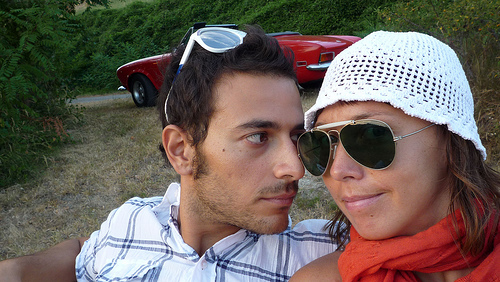

In [ ]:
im = test_img[int(np.random.randint(0, 1000, size=1))]
print (im)
print ('Normal Max search:', predict_captions(im))
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))
Image.open(im)

Get Quantaized features

Extract Features

In [ ]:
def getQuantizedModel(model):

  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  
  tflite_model = converter.convert()
  
  tflite_models_dir = pathlib.Path("/content/drive/MyDrive/MasterCode")
  tflite_models_dir.mkdir(exist_ok=True, parents=True)

  tflite_model_file = tflite_models_dir/"no_Q_model.tflite"
  tflite_model_file.write_bytes(tflite_model)
  #converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
  #converter._experimental_lower_tensor_list_ops = False
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  tflite_quant_model = converter.convert()
  tflite_model_quant_file = tflite_models_dir/"Q_model.tflite"
  tflite_model_quant_file.write_bytes(tflite_quant_model)

  interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
  interpreter_quant.allocate_tensors()
  return interpreter_quant

In [ ]:
interpreter = getQuantizedModel(model_new)

INFO:tensorflow:Assets written to: /tmp/tmpyxgu81dd/assets


INFO:tensorflow:Assets written to: /tmp/tmpsvowbz9m/assets


INFO:tensorflow:Assets written to: /tmp/tmpsvowbz9m/assets


In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path="/content/drive/MyDrive/MasterCode/no_Q_model.tflite",gpu_compatibility=False)

=== /content/drive/MyDrive/MasterCode/no_Q_model.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #96 and tensor #2 as input and produces tensor #190 as output.

Subgraph#0 main(T#0) -> [T#312]
  Op#0 CONV_2D(T#0, T#96, T#2) -> [T#190]
  Op#1 CONV_2D(T#190, T#97, T#3) -> [T#191]
  Op#2 CONV_2D(T#191, T#98, T#4) -> [T#192]
  Op#3 MAX_POOL_2D(T#192) -> [T#193]
  Op#4 CONV_2D(T#193, T#99, T#5) -> [T#194]
  Op#5 CONV_2D(T#194, T#100, T#6) -> [T#195]
  Op#6 MAX_POOL_2D(T#195) -> [T#196]
  Op#7 AVERAGE_POOL_2D(T#196) -> [T#197]
  Op#8 CONV_2D(T#197, T#101, T#7) -> [T#198]
  Op#9 CONV_2D(T#196, T#102, T#8) -> [T#199]
  Op#10 CONV_2D(T#196, T#103, T#9) -> [T#200]
  Op#11 CONV_2D(T#200, T#104, T#10) -> [T#201]
  Op#12 CONV_2D(T#196, T#105, T#11) -> [T#202]
  Op#13 CONV_2D(T#202, T#106, T#12) -> [T#203]
  Op#14 CONV_2D(T#203, T#107, T#13) -> [T#204]
  Op#15

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path="/content/drive/MyDrive/MasterCode/Q_model.tflite",gpu_compatibility=False)

=== /content/drive/MyDrive/MasterCode/Q_model.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CONV_2D op takes
tensor #0 and tensor #96 and tensor #2 as input and produces tensor #190 as output.

Subgraph#0 main(T#0) -> [T#312]
  Op#0 CONV_2D(T#0, T#96, T#2) -> [T#190]
  Op#1 CONV_2D(T#190, T#97, T#3) -> [T#191]
  Op#2 CONV_2D(T#191, T#98, T#4) -> [T#192]
  Op#3 MAX_POOL_2D(T#192) -> [T#193]
  Op#4 CONV_2D(T#193, T#99, T#5) -> [T#194]
  Op#5 CONV_2D(T#194, T#100, T#6) -> [T#195]
  Op#6 MAX_POOL_2D(T#195) -> [T#196]
  Op#7 AVERAGE_POOL_2D(T#196) -> [T#197]
  Op#8 CONV_2D(T#197, T#101, T#7) -> [T#198]
  Op#9 CONV_2D(T#196, T#102, T#8) -> [T#199]
  Op#10 CONV_2D(T#196, T#103, T#9) -> [T#200]
  Op#11 CONV_2D(T#200, T#104, T#10) -> [T#201]
  Op#12 CONV_2D(T#196, T#105, T#11) -> [T#202]
  Op#13 CONV_2D(T#202, T#106, T#12) -> [T#203]
  Op#14 CONV_2D(T#203, T#107, T#13) -> [T#204]
  Op#15 CO

In [ ]:
input_details = interpreter.get_input_details()

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_1:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 299, 299,   3], dtype=int32),
  'shape_signature': array([ -1, 299, 299,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details = interpreter.get_output_details()

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 312,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([   1, 2048], dtype=int32),
  'shape_signature': array([  -1, 2048], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
#input_index = []
#if interpreter.get_input_details()[0]['shape'][1] == 34:
#  input_index.append(interpreter.get_input_details()[1]["index"])
#  input_index.append(interpreter.get_input_details()[0]["index"])
#else:
 # input_index.append(interpreter.get_input_details()[0]["index"])
 # input_index.append(interpreter.get_input_details()[1]["index"])
 # output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
interpreter.get_input_details()[0]['shape'][0]


1

In [ ]:
interpreter.get_input_details()[0]['shape'][1]

299

In [ ]:
interpreter.get_input_details()[0]['shape'][2]

299

In [ ]:
input_index = interpreter.get_input_details()[0]["index"]

In [ ]:
input_index

0

In [ ]:
output_index = interpreter.get_output_details()[0]["index"]

In [ ]:
output_index

312

In [ ]:
def extract_features_quantized(extractor,file,ts=(299, 299)):
	image = load_img(file, target_size=ts)
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)

	input_index = extractor.get_input_details()[0]["index"]
	output_index = extractor.get_output_details()[0]["index"]

	extractor.set_tensor(input_index, image)
	feature = extractor.invoke()
	feature = extractor.get_tensor(output_index)[0]
	feature = feature.reshape(1,-1)
	return feature

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3320032226_63390d74a6.jpg'

In [ ]:
# extract features from each photo in the directory
def extract_features(model,file,ts=(299, 299)):
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	image = load_img(file, target_size=ts)
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)
	feature = model.predict(image, verbose=0)
	return feature

In [ ]:
testfeature = extract_features(model,im)

In [ ]:
testfeature

array([[0.37313527, 0.4436168 , 1.2947042 , ..., 0.7514595 , 0.44886458,
        0.27046746]], dtype=float32)

In [ ]:
testfeature.size

2048

In [ ]:
testfeature_quant = extract_features_quantized(interpreter,im)

In [ ]:
testfeature_quant

array([[0.36366397, 0.42455694, 1.3363965 , ..., 0.7450218 , 0.434707  ,
        0.26394427]], dtype=float32)

In [ ]:
testfeature_quant.size

2048

In [ ]:
len(test_img)

1000

In [ ]:
type(test_img)

list

In [ ]:
test_img[0]

'/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/387830531_e89c192b92.jpg'

In [ ]:
# extract quantized_model features from each photo in the directory
def extract_quantized_features_tofile(directory_list,quantized_model):
	# load the model
  features = dict()
  
  input_index = quantized_model.get_input_details()[0]["index"]
  output_index = quantized_model.get_output_details()[0]["index"]
	
  # extract features from each photo
  for name in tqdm(directory_list):
		# load an image from file
    filename=name
    #print(filename)
    image = load_img(filename, target_size=(299, 299))
		# convert the image pixels to a numpy array
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the InceptionV3 model 
    image = preprocess_input(image)
		# get features
    quantized_model.set_tensor(input_index, image)
		# Run inference.
    feature = quantized_model.invoke()
	
		# get image id
    image_id = name.split('.')[0]
    #print(image_id)
    feature = quantized_model.get_tensor(output_index)[0]
	  # Store feature with its key in dictionary
    feature = feature.reshape(1,-1)
    features[image_id] = feature
  return features

In [ ]:
#quantized_trained_features = extract_quantized_features_tofile(train_img,interpreter)
#print('extract_quantized_features_tofile: %d' % len(quantized_trained_features))


In [ ]:
# save to file
#pk.dump(quantized_trained_features, open('/content/drive/MyDrive/MasterCode' + 'Train_Quantized_Extracted_feature', 'wb'))

In [ ]:
#quantized_testing_features = extract_quantized_features_tofile(test_img,interpreter)
#print('extract_quantized_features_tofile: %d' % len(quantized_testing_features))


In [ ]:
def predict_captions_interpreter_encoder(image,interpreter):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        #e = encoding_test[image[len(images):]]
        output = extract_features_quantized(interpreter,image)
        #print(output)
        #print(output.size)
        
        preds = final_model.predict([output, np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        #print(word_pred,"\t")
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
# evaluate the skill of the model
def evaluate_model_basic_test_images(test_d,encoder_final_quant,encoder_interpreter,decoder_interpreter):
  actual, predicted = list(), list()
  cnt = 0
  start = time.time()
  for key, desc_list in test_d.items():
    cnt= cnt+1
    print(cnt)
    if encoder_final_quant == 1:
      print("\n ****** Encoder Only Quantization: ") 
      yhat = predict_captions_interpreter_encoder(key,encoder_interpreter)
    elif encoder_final_quant == 2:
      print("\n ****** NO Encoder Quantization and Final Model Quantization: ")
      yhat = predict_captions_interpreter_encoder_full(key,encoder_interpreter,decoder_interpreter,False)
    elif encoder_final_quant == 3:
      print("\n ****** Encoder and Final Model Quantization: ")
      yhat = predict_captions_interpreter_encoder_full(key,encoder_interpreter,decoder_interpreter,True)
    else:
      print("\n ****** Model Quantization: ")
      yhat = predict_captions(key)

    references = [desp.split() for desp in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
    
    if cnt == 30 : 
        break
     #   print('ACTUAL- TEXT:')
      #  print(actual)
    
       # print('PREDICTED- TEXT:')
       # print(predicted)
        
  #print('FULL ACTUAL- TEXT: ')
  #print('FULL PREDICTED- TEXT: ')
  print("\n ****** Time taken: ", (time.time()-start)/60)  
  #calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3320032226_63390d74a6.jpg
Normal Max search: A young boy in a red jacket is walking on the ice .


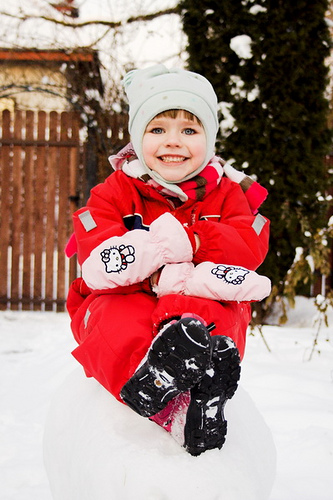

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3320032226_63390d74a6.jpg'
print (im)
quatized_prediction = predict_captions_interpreter_encoder(im,interpreter)
print ('Normal Max search:', quatized_prediction)
Image.open(im)


In [ ]:
def beam_search_predictions_encoder_interpreter(image,interpreter, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            output = extract_features_quantized(interpreter,image)      
            preds = final_model.predict([output, np.array(par_caps)])
            #e = encoding_test[image[len(images):]]
            #preds = final_model.predict([np.array([e]), np.array(par_caps)])
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

Normal Max search: A dog jumps over a hurdle .


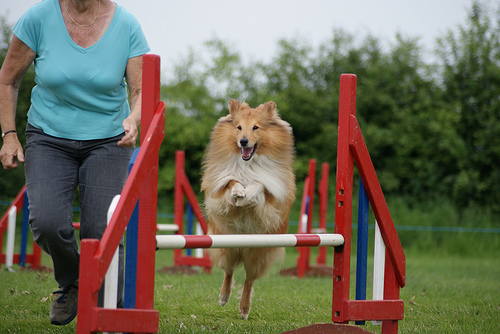

In [ ]:
#im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3320032226_63390d74a6.jpg'
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2542662402_d781dd7f7c.jpg'
print ('Normal Max search:', predict_captions_interpreter_encoder(im,interpreter))
Image.open(im)
#print('Beam Search, k=3:', beam_search_predictions_encoder_interpreter(im,interpreter, beam_index=3))
#print('Beam Search, k=5:', beam_search_predictions_encoder_interpreter(im,interpreter, beam_index=5))
#print('Beam Search, k=7:', beam_search_predictions_encoder_interpreter(im,interpreter, beam_index=7))

In [ ]:
print ('Normal Max search:', predict_captions(im)) 
print ('Beam Search, k=3:', beam_search_predictions(im, beam_index=3))
print ('Beam Search, k=5:', beam_search_predictions(im, beam_index=5))
print ('Beam Search, k=7:', beam_search_predictions(im, beam_index=7))

Normal Max search: A dog jumps over a hurdle .
Beam Search, k=3: A black and white dog jumps over a hurdle .
Beam Search, k=5: A black and white dog jumps over a hurdle .
Beam Search, k=7: A black and white dog jumps over a hurdle .


Final Model Quantization

In [ ]:
def getQuantizedModel_full(model):

  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
  converter._experimental_lower_tensor_list_ops = False  
  tflite_model = converter.convert()
  
  tflite_models_dir = pathlib.Path("/content/drive/MyDrive/MasterCode")
  tflite_models_dir.mkdir(exist_ok=True, parents=True)

  tflite_model_file = tflite_models_dir/"no_Q_model_full.tflite"
  tflite_model_file.write_bytes(tflite_model)
  
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
  converter._experimental_lower_tensor_list_ops = False
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  tflite_quant_model = converter.convert()
  tflite_model_quant_file = tflite_models_dir/"Q_model_full.tflite"
  tflite_model_quant_file.write_bytes(tflite_quant_model)

  interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
  interpreter_quant.allocate_tensors()
  return interpreter_quant

In [ ]:
interpreter_final = getQuantizedModel_full(final_model)

INFO:tensorflow:Assets written to: /tmp/tmpt8ce107v/assets


INFO:tensorflow:Assets written to: /tmp/tmpt8ce107v/assets


INFO:tensorflow:Assets written to: /tmp/tmpxfuief4r/assets


INFO:tensorflow:Assets written to: /tmp/tmpxfuief4r/assets


In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path="/content/drive/MyDrive/MasterCode/no_Q_model_full.tflite",gpu_compatibility=False)

=== /content/drive/MyDrive/MasterCode/no_Q_model_full.tflite ===

Your TFLite model has '3' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CAST op takes
tensor #0 as input and produces tensor #28 as output.

Subgraph#0 main(T#0, T#1) -> [T#74]
  Op#0 CAST(T#0) -> [T#28]
  Op#1 NOT_EQUAL(T#0, T#8) -> [T#29]
  Op#2 FULLY_CONNECTED(T#1, T#18, T#6) -> [T#30]
  Op#3 GATHER(T#3, T#28) -> [T#31]
  Op#4 SHAPE(T#31) -> [T#32]
  Op#5 STRIDED_SLICE(T#32, T#13, T#12, T#12) -> [T#33]
  Op#6 PACK(T#33, T#7) -> [T#34]
  Op#7 FILL(T#34, T#8) -> [T#35]
  Op#8 EXPAND_DIMS(T#29, T#9) -> [T#36]
  Op#9 FULLY_CONNECTED(T#35, T#19, T#-1) -> [T#37]
  Op#10 TRANSPOSE(T#31, T#11) -> [T#38]
  Op#11 FlexTensorListReserve(T#15, T#17) -> [T#39]
  Op#12 FlexTensorListFromTensor(T#38, T#15) -> [T#40]
  Op#13 STRIDED_SLICE(T#38, T#23, T#24, T#25) -> [T#41]
  Op#14 FULLY_CONNECTED(T#41, T#20, T#-1) -> [T#42]
  Op#15 ADD(T#42, T#37) -> [T#43]
  Op#16 ADD

In [ ]:
tf.lite.experimental.Analyzer.analyze(model_path="/content/drive/MyDrive/MasterCode/Q_model_full.tflite",gpu_compatibility=False)

=== /content/drive/MyDrive/MasterCode/Q_model_full.tflite ===

Your TFLite model has '3' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the CAST op takes
tensor #0 as input and produces tensor #28 as output.

Subgraph#0 main(T#0, T#1) -> [T#74]
  Op#0 CAST(T#0) -> [T#28]
  Op#1 NOT_EQUAL(T#0, T#8) -> [T#29]
  Op#2 FULLY_CONNECTED(T#1, T#18, T#6) -> [T#30]
  Op#3 GATHER(T#3, T#28) -> [T#31]
  Op#4 DEQUANTIZE(T#31) -> [T#75]
  Op#5 SHAPE(T#75) -> [T#32]
  Op#6 STRIDED_SLICE(T#32, T#13, T#12, T#12) -> [T#33]
  Op#7 PACK(T#33, T#7) -> [T#34]
  Op#8 FILL(T#34, T#8) -> [T#35]
  Op#9 EXPAND_DIMS(T#29, T#9) -> [T#36]
  Op#10 FULLY_CONNECTED(T#35, T#19, T#-1) -> [T#37]
  Op#11 TRANSPOSE(T#75, T#11) -> [T#38]
  Op#12 FlexTensorListReserve(T#15, T#17) -> [T#39]
  Op#13 FlexTensorListFromTensor(T#38, T#15) -> [T#40]
  Op#14 STRIDED_SLICE(T#38, T#23, T#24, T#25) -> [T#41]
  Op#15 FULLY_CONNECTED(T#41, T#20, T#-1) -> [T#42]
  Op#16 ADD(T

In [ ]:
output_details_final = interpreter_final.get_output_details()

In [ ]:
output_details_final

[{'dtype': numpy.float32,
  'index': 74,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([   1, 8256], dtype=int32),
  'shape_signature': array([  -1, 8256], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
input_details_final = interpreter_final.get_input_details()

In [ ]:
input_details_final

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_3:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 40], dtype=int32),
  'shape_signature': array([-1, 40], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 1,
  'name': 'serving_default_input_2:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([   1, 2048], dtype=int32),
  'shape_signature': array([  -1, 2048], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
interpreter_final.get_input_details()[1]["index"]

1

In [ ]:
def extract_final_model_quantized(final_extractor,feature_output,caps_out):
  input_index_0 = final_extractor.get_input_details()[0]["index"]
  input_index_1 = final_extractor.get_input_details()[1]["index"]
  output_index = final_extractor.get_output_details()[0]["index"]
  caps_out_float = caps_out.astype(np.float32)
  final_extractor.set_tensor(input_index_0, caps_out_float)
  final_extractor.set_tensor(input_index_1, feature_output)
  
  final_description = final_extractor.invoke()
  final_description = final_extractor.get_tensor(output_index)[0]
  final_description = final_description.reshape(1,-1)
  return final_description

In [ ]:
def predict_captions_interpreter_encoder_full(image,encoder_interpreter,decoder_interpreter,yes_encoder=True):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        #e = encoding_test[image[len(images):]]
        if yes_encoder == True:
          feature_output = extract_features_quantized(encoder_interpreter,image)
          preds = extract_final_model_quantized(decoder_interpreter,feature_output,np.array(par_caps))
        else:
          feature_output = encoding_test[image[len(images):]]
          preds = extract_final_model_quantized(decoder_interpreter,np.array([feature_output]),np.array(par_caps))
          #print(preds)
        #print(output.size)
  
        #preds = final_model.predict([output, np.array(par_caps)])
        
        word_pred = idx2word[np.argmax(preds[0])]
        #print(word_pred,"\t")
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [ ]:
print('Normal Max search:', predict_captions_interpreter_encoder_full(im,interpreter,interpreter_final)) 

Normal Max search: A man is standing on a ledge in front of a large wooden railing .


In [ ]:
print('Normal Max search:', predict_captions_interpreter_encoder_full(im,interpreter,interpreter_final,False))

Normal Max search: A man is standing on a ledge in front of a yellow building .


In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2542662402_d781dd7f7c.jpg'

In [ ]:
d['2542662402_d781dd7f7c.jpg']

['A woman in a blue shirt guides her dog over an obstacle .',
 'a woman is running beside a dog that is jumping over a red and white obedience training fence .',
 'A woman next to a dog which is running an obstacle course .',
 'A woman walking with a Sheltie through a competition obstacle course .',
 'The dog is jumping over the hurdles beside a woman .']

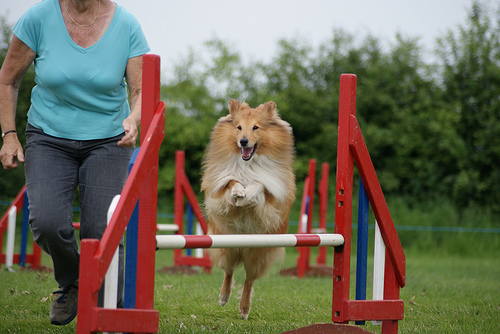

In [ ]:
Image.open(im)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
im = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2542662402_d781dd7f7c.jpg'
print ('Normal Max search:', predict_captions_interpreter_encoder(im,interpreter))


In [ ]:
d['2542662402_d781dd7f7c.jpg']

['A woman in a blue shirt guides her dog over an obstacle .',
 'a woman is running beside a dog that is jumping over a red and white obedience training fence .',
 'A woman next to a dog which is running an obstacle course .',
 'A woman walking with a Sheltie through a competition obstacle course .',
 'The dog is jumping over the hurdles beside a woman .']

In [ ]:
import time

In [ ]:
# evaluate the skill of the model
def evaluate_model_basic_oneimage(img_path,img_str_key,encoder_final_quant=0,encoder_interpreter=False,decoder_interpreter=False):
  actual, predicted = list(), list()
  start = time.time()
  if encoder_final_quant == 1:
    print("\n ****** Encoder Only Quantization: ") 
    yhat = predict_captions_interpreter_encoder(img_path,encoder_interpreter)
  elif encoder_final_quant == 2:
    print("\n ****** No Encoder Quantization and Final Model Quantization: ")
    yhat = predict_captions_interpreter_encoder_full(img_path,encoder_interpreter,decoder_interpreter,False)
  elif encoder_final_quant == 3:
    print("\n ****** Encoder and Final Model Quantization: ")
    yhat = predict_captions_interpreter_encoder_full(img_path,encoder_interpreter,decoder_interpreter,True)
  else:
    print("\n ******NO Model Quantization: ")
    yhat = predict_captions(img_path)
  
  print("\n****** Time taken: ", (time.time()-start)/60)  
  
  references = [desp.split() for desp in d[img_str_key]]
  actual.append(references)
  predicted.append(yhat.split())
  print('ACTUAL- TEXT:')
  print(d[img_str_key])
  #predicted_text = ' '.join(predicted[1:-1]
  print('PREDICTED- TEXT:')
  print(yhat)
 	
	# calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
evaluate_model_basic_oneimage('/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2542662402_d781dd7f7c.jpg','2542662402_d781dd7f7c.jpg')



 ******NO Model Quantization: 

****** Time taken:  0.0074456572532653805
ACTUAL- TEXT:
['A woman in a blue shirt guides her dog over an obstacle .', 'a woman is running beside a dog that is jumping over a red and white obedience training fence .', 'A woman next to a dog which is running an obstacle course .', 'A woman walking with a Sheltie through a competition obstacle course .', 'The dog is jumping over the hurdles beside a woman .']
PREDICTED- TEXT:
A dog jumps over a hurdle .
BLEU-1: 0.403370
BLEU-2: 0.194846
BLEU-3: 0.298228
BLEU-4: 0.331713


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate_model_basic_oneimage('/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2542662402_d781dd7f7c.jpg','2542662402_d781dd7f7c.jpg',1,interpreter,interpreter_final)



 ****** Encoder Only Quantization: 

****** Time taken:  1.9810625433921814
ACTUAL- TEXT:
['A woman in a blue shirt guides her dog over an obstacle .', 'a woman is running beside a dog that is jumping over a red and white obedience training fence .', 'A woman next to a dog which is running an obstacle course .', 'A woman walking with a Sheltie through a competition obstacle course .', 'The dog is jumping over the hurdles beside a woman .']
PREDICTED- TEXT:
A dog jumps over a hurdle .
BLEU-1: 0.403370
BLEU-2: 0.194846
BLEU-3: 0.298228
BLEU-4: 0.331713


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate_model_basic_oneimage('/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2542662402_d781dd7f7c.jpg','2542662402_d781dd7f7c.jpg',2,interpreter,interpreter_final)



 ****** No Encoder Quantization and Final Model Quantization: 

****** Time taken:  0.000834194819132487
ACTUAL- TEXT:
['A woman in a blue shirt guides her dog over an obstacle .', 'a woman is running beside a dog that is jumping over a red and white obedience training fence .', 'A woman next to a dog which is running an obstacle course .', 'A woman walking with a Sheltie through a competition obstacle course .', 'The dog is jumping over the hurdles beside a woman .']
PREDICTED- TEXT:
A dog jumps over a hurdle .
BLEU-1: 0.403370
BLEU-2: 0.194846
BLEU-3: 0.298228
BLEU-4: 0.331713


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
evaluate_model_basic_oneimage('/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2542662402_d781dd7f7c.jpg','2542662402_d781dd7f7c.jpg',3,interpreter,interpreter_final)



 ****** Encoder and Final Model Quantization: 

****** Time taken:  1.9819096803665162
ACTUAL- TEXT:
['A woman in a blue shirt guides her dog over an obstacle .', 'a woman is running beside a dog that is jumping over a red and white obedience training fence .', 'A woman next to a dog which is running an obstacle course .', 'A woman walking with a Sheltie through a competition obstacle course .', 'The dog is jumping over the hurdles beside a woman .']
PREDICTED- TEXT:
A dog jumps over a hurdle .
BLEU-1: 0.403370
BLEU-2: 0.194846
BLEU-3: 0.298228
BLEU-4: 0.331713


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
im2 = test_img[int(np.random.randint(0, 1000, size=1))]
im2_name = im2.split(os.sep)[-1]
print(im2,im2_name)

/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/1679617928_a73c1769be.jpg 1679617928_a73c1769be.jpg


/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3044500219_778f9f2b71.jpg 3044500219_778f9f2b71.jpg

 ******NO Model Quantization: 

****** Time taken:  0.01759215195973714
ACTUAL- TEXT:
['Four girls in evening attire pose for a picture .', 'four girls in evening wear are posing for a photograph .', 'Four woman wearing formal gowns pose together and smile .', 'Four women are standing together , posing for a picture .', 'Four women in dresses pose together .']
PREDICTED- TEXT:
A woman in a pink dress is standing in front of a woman wearing a black dress .
BLEU-1: 0.333333
BLEU-2: 0.140028
BLEU-3: 0.307418
BLEU-4: 0.374203

 ****** Encoder Only Quantization: 


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)



****** Time taken:  4.942373891671498
ACTUAL- TEXT:
['Four girls in evening attire pose for a picture .', 'four girls in evening wear are posing for a photograph .', 'Four woman wearing formal gowns pose together and smile .', 'Four women are standing together , posing for a picture .', 'Four women in dresses pose together .']
PREDICTED- TEXT:
A woman in a pink jacket and a woman in a white shirt are posing for a picture .
BLEU-1: 0.473684
BLEU-2: 0.362738
BLEU-3: 0.352565
BLEU-4: 0.276026

 ****** No Encoder Quantization and Final Model Quantization: 

****** Time taken:  0.001932366689046224
ACTUAL- TEXT:
['Four girls in evening attire pose for a picture .', 'four girls in evening wear are posing for a photograph .', 'Four woman wearing formal gowns pose together and smile .', 'Four women are standing together , posing for a picture .', 'Four women in dresses pose together .']
PREDICTED- TEXT:
A woman in a pink jacket and a woman in a white shirt are posing for a picture .
BLEU-1: 0

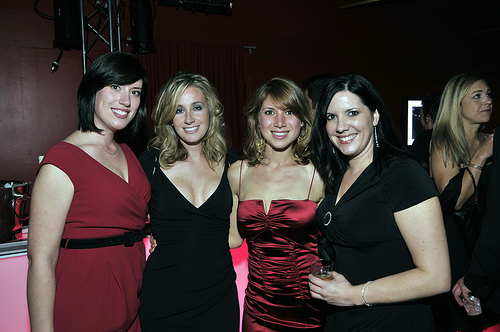

In [ ]:
im2 = test_img[int(np.random.randint(0, 1000, size=1))]
im2_name = im2.split(os.sep)[-1]
print(im2,im2_name)
evaluate_model_basic_oneimage(im2,im2_name,0,interpreter,interpreter_final)
evaluate_model_basic_oneimage(im2,im2_name,1,interpreter,interpreter_final)
evaluate_model_basic_oneimage(im2,im2_name,2,interpreter,interpreter_final)
evaluate_model_basic_oneimage(im2,im2_name,3,interpreter,interpreter_final)
Image.open(im2)

/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/2621415349_ef1a7e73be.jpg 2621415349_ef1a7e73be.jpg

 ******NO Model Quantization: 

****** Time taken:  0.017423192660013836
ACTUAL- TEXT:
['A man in a red baseball cap eats a chip .', 'a man wearing a red hat has a potato chip in his mouth', 'A man wearing sunglasses and a red cap putting a chip in his mouth .', 'A man wearing sunglasses and a red hat is opening his mouth wide and eating a chip .', 'A man with sunglasses on puts a chip in his mouth .']
PREDICTED- TEXT:
A man in a black shirt and glasses talks to a man in a black shirt .
BLEU-1: 0.443705
BLEU-2: 0.323403
BLEU-3: 0.271087
BLEU-4: 0.172505

 ****** Encoder Only Quantization: 

****** Time taken:  4.441792670885722
ACTUAL- TEXT:
['A man in a red baseball cap eats a chip .', 'a man wearing a red hat has a potato chip in his mouth', 'A man wearing sunglasses and a red cap putting a chip in his mouth .', 'A man wearing sunglasses and a red hat is opening his mouth wide and 

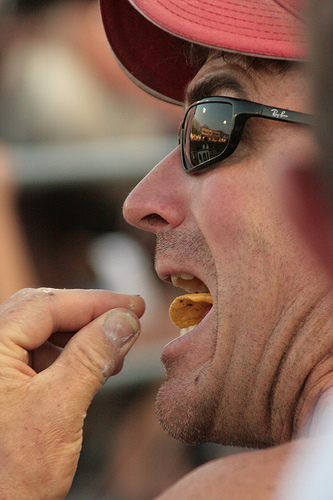

In [ ]:
im2 = test_img[int(np.random.randint(0, 1000, size=1))]
im2_name = im2.split(os.sep)[-1]
print(im2,im2_name)
evaluate_model_basic_oneimage(im2,im2_name,0,interpreter,interpreter_final)
evaluate_model_basic_oneimage(im2,im2_name,1,interpreter,interpreter_final)
evaluate_model_basic_oneimage(im2,im2_name,2,interpreter,interpreter_final)
evaluate_model_basic_oneimage(im2,im2_name,3,interpreter,interpreter_final)
Image.open(im2)

In [ ]:
# evaluate the skill of the model
def evaluate_model_basic_trained_images(encoder_final_quant,encoder_interpreter,decoder_interpreter):
  actual, predicted = list(), list()
  cnt = 0
  start = time.time()
  for key, desc_list in test_d.items():
    cnt= cnt+1
    print(cnt)
    if encoder_final_quant == 1:
      print("\n ****** Encoder Only Quantization: ") 
      yhat = predict_captions_interpreter_encoder(key,encoder_interpreter)
    elif encoder_final_quant == 2:
      print("\n ****** Encoder Quantization and Final Model Quantization: ")
      yhat = predict_captions_interpreter_encoder_full(key,encoder_interpreter,decoder_interpreter,False)
    elif encoder_final_quant == 3:
      print("\n ****** Encoder and Final Model Quantization: ")
      yhat = predict_captions_interpreter_encoder_full(key,encoder_interpreter,decoder_interpreter,True)
    else:
      print("\n ****** Model Quantization: ")
      yhat = predict_captions(key)

    if cnt == 30:
      break

    references = [desp.split() for desp in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  
  #print('FULL ACTUAL- TEXT: ')
  #print('FULL PREDICTED- TEXT: ')
  print("\n****** Time taken: ", (time.time()-start)/60)  
	# calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
evaluate_model_basic_trained_images(0,interpreter,interpreter_final)
#evaluate_model_basic_oneimage(2,interpreter,interpreter_final)


1

 ****** Model Quantization: 
2

 ****** Model Quantization: 
3

 ****** Model Quantization: 
4

 ****** Model Quantization: 
5

 ****** Model Quantization: 
6

 ****** Model Quantization: 
7

 ****** Model Quantization: 
8

 ****** Model Quantization: 
9

 ****** Model Quantization: 
10

 ****** Model Quantization: 
11

 ****** Model Quantization: 
12

 ****** Model Quantization: 
13

 ****** Model Quantization: 
14

 ****** Model Quantization: 
15

 ****** Model Quantization: 
16

 ****** Model Quantization: 
17

 ****** Model Quantization: 
18

 ****** Model Quantization: 
19

 ****** Model Quantization: 
20

 ****** Model Quantization: 
21

 ****** Model Quantization: 
22

 ****** Model Quantization: 
23

 ****** Model Quantization: 
24

 ****** Model Quantization: 
25

 ****** Model Quantization: 
26

 ****** Model Quantization: 
27

 ****** Model Quantization: 
28

 ****** Model Quantization: 
29

 ****** Model Quantization: 
30

 ****** Model Quantization: 

****** Time taken:

In [ ]:
evaluate_model_basic_trained_images(1,interpreter,interpreter_final)

1

 ****** Encoder Only Quantization: 
2

 ****** Encoder Only Quantization: 
3

 ****** Encoder Only Quantization: 
4

 ****** Encoder Only Quantization: 
5

 ****** Encoder Only Quantization: 
6

 ****** Encoder Only Quantization: 
7

 ****** Encoder Only Quantization: 
8

 ****** Encoder Only Quantization: 
9

 ****** Encoder Only Quantization: 
10

 ****** Encoder Only Quantization: 
11

 ****** Encoder Only Quantization: 
12

 ****** Encoder Only Quantization: 
13

 ****** Encoder Only Quantization: 
14

 ****** Encoder Only Quantization: 
15

 ****** Encoder Only Quantization: 
16

 ****** Encoder Only Quantization: 
17

 ****** Encoder Only Quantization: 
18

 ****** Encoder Only Quantization: 
19

 ****** Encoder Only Quantization: 
20

 ****** Encoder Only Quantization: 
21

 ****** Encoder Only Quantization: 
22

 ****** Encoder Only Quantization: 
23

 ****** Encoder Only Quantization: 
24

 ****** Encoder Only Quantization: 
25

 ****** Encoder Only Quantization: 
26

 ****

In [ ]:
evaluate_model_basic_trained_images(2,interpreter,interpreter_final)

1

 ****** Encoder Quantization and Final Model Quantization: 
2

 ****** Encoder Quantization and Final Model Quantization: 
3

 ****** Encoder Quantization and Final Model Quantization: 
4

 ****** Encoder Quantization and Final Model Quantization: 
5

 ****** Encoder Quantization and Final Model Quantization: 
6

 ****** Encoder Quantization and Final Model Quantization: 
7

 ****** Encoder Quantization and Final Model Quantization: 
8

 ****** Encoder Quantization and Final Model Quantization: 
9

 ****** Encoder Quantization and Final Model Quantization: 
10

 ****** Encoder Quantization and Final Model Quantization: 
11

 ****** Encoder Quantization and Final Model Quantization: 
12

 ****** Encoder Quantization and Final Model Quantization: 
13

 ****** Encoder Quantization and Final Model Quantization: 
14

 ****** Encoder Quantization and Final Model Quantization: 
15

 ****** Encoder Quantization and Final Model Quantization: 
16

 ****** Encoder Quantization and Final Model 

In [ ]:
evaluate_model_basic_trained_images(3,interpreter,interpreter_final)

1

 ****** Encoder and Final Model Quantization: 
2

 ****** Encoder and Final Model Quantization: 
3

 ****** Encoder and Final Model Quantization: 
4

 ****** Encoder and Final Model Quantization: 
5

 ****** Encoder and Final Model Quantization: 
6

 ****** Encoder and Final Model Quantization: 
7

 ****** Encoder and Final Model Quantization: 
8

 ****** Encoder and Final Model Quantization: 
9

 ****** Encoder and Final Model Quantization: 
10

 ****** Encoder and Final Model Quantization: 
11

 ****** Encoder and Final Model Quantization: 
12

 ****** Encoder and Final Model Quantization: 
13

 ****** Encoder and Final Model Quantization: 
14

 ****** Encoder and Final Model Quantization: 
15

 ****** Encoder and Final Model Quantization: 
16

 ****** Encoder and Final Model Quantization: 
17

 ****** Encoder and Final Model Quantization: 
18

 ****** Encoder and Final Model Quantization: 
19

 ****** Encoder and Final Model Quantization: 
20

 ****** Encoder and Final Model Quan

In [ ]:
#this is for zerooption
evaluate_model_basic_trained_images()

/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/387830531_e89c192b92.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3741827382_71e93298d0.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/373394550_1b2296b8c4.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/405615014_03be7ef618.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/391579205_c8373b5411.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/400851260_5911898657.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3741462565_cc35966b7a.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3727752439_907795603b.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3737539561_d1dc161040.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/3767841911_6678052eb6.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/444057017_f1e0fcaef7.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/447111935_5af98563e3.jpg
/content/drive/MyDrive/MasterCode/Flickr8k_Dataset/422763475_0bc814dac6.jpg
/conten

In [ ]:
def beam_search_predictions_encoder_interpreter_full(image,encoder_interpreter,decoder_interpreter,beam_index,yes_encoder):
  start = [word2idx["<start>"]]
  start_word = [[start, 0.0]]
    
  while len(start_word[0][0]) < max_len:
      temp = []
      for s in start_word:
          par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
          
          if yes_encoder == True:
            output = extract_features_quantized(interpreter,image)   
            preds = extract_final_model_quantized(decoder_interpreter,output,np.array(par_caps))
          else:
           output = encoding_test[image[len(images):]] 
           preds = extract_final_model_quantized(decoder_interpreter,np.array([output]),np.array(par_caps))

          #preds = final_model.predict([output, np.array(par_caps)])
          #e = encoding_test[image[len(images):]]
          #preds = final_model.predict([np.array([e]), np.array(par_caps)])
          word_preds = np.argsort(preds[0])[-beam_index:]
          
          # Getting the top <beam_index>(n) predictions and creating a 
          # new list so as to put them via the model again
          for w in word_preds:
              next_cap, prob = s[0][:], s[1]
              next_cap.append(w)
              prob += preds[0][w]
              temp.append([next_cap, prob])
                  
      start_word = temp
      # Sorting according to the probabilities
      start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
      # Getting the top words
      start_word = start_word[-beam_index:]
    
  start_word = start_word[-1][0]
  intermediate_caption = [idx2word[i] for i in start_word]

  final_caption = []
    
  for i in intermediate_caption:
      if i != '<end>':
          final_caption.append(i)
      else:
          break
  
  final_caption = ' '.join(final_caption[1:])
  return final_caption


In [ ]:
def evaluate_model_basic_trained_bleu_images(encoder_interpreter, decoder_interpreter,encoder_final_quant,beam_index = 3):
  actual, predicted = list(), list()
  cnt = 0
  start = time.time()
  for key, desc_list in test_d.items():
    cnt= cnt+1
    print(cnt)
    if encoder_final_quant == 1:
      print("\n ****** Beam Encoder Only Quantization: ") 
      #yhat = predict_captions_interpreter_encoder(key,encoder_interpreter)
      yhat = beam_search_predictions_encoder_interpreter(key,encoder_interpreter,beam_index)
    elif encoder_final_quant == 2:
      print("\n ****** Beam NO Encoder Quantization and Final Model Quantization: ")
      yhat = beam_search_predictions_encoder_interpreter_full(key,encoder_interpreter,decoder_interpreter,beam_index,False)
    elif encoder_final_quant == 3:
      print("\n ****** Beam Encoder and Final Model Quantization: ")
      yhat = beam_search_predictions_encoder_interpreter_full(key,encoder_interpreter,decoder_interpreter,beam_index,True)
    else:
      print("\n ****** Beam Model Quantization: ")
      yhat = beam_search_predictions(key,beam_index)

    references = [desp.split() for desp in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
    
    if cnt == 5 : 
        break
     #   print('ACTUAL- TEXT:')
      #  print(actual)
    
       # print('PREDICTED- TEXT:')
       # print(predicted)
        
  #print('FULL ACTUAL- TEXT: ')
  #print('FULL PREDICTED- TEXT: ')
  print("\n ****** Time taken: ", (time.time()-start)/60)  
  #calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
evaluate_model_basic_trained_bleu_images(interpreter,interpreter_final,0,beam_index = 3) 

1

 ****** Beam Model Quantization: 
2

 ****** Beam Model Quantization: 
3

 ****** Beam Model Quantization: 
4

 ****** Beam Model Quantization: 
5

 ****** Beam Model Quantization: 

 ****** Time taken:  0.8566721240679424
BLEU-1: 0.483333
BLEU-2: 0.310913
BLEU-3: 0.188887
BLEU-4: 0.096279


In [ ]:
evaluate_model_basic_trained_bleu_images(interpreter,interpreter_final,1,beam_index = 3) 

1

 ****** Beam Encoder Only Quantization: 
2

 ****** Beam Encoder Only Quantization: 
3

 ****** Beam Encoder Only Quantization: 
4

 ****** Beam Encoder Only Quantization: 
5

 ****** Beam Encoder Only Quantization: 

 ****** Time taken:  163.70774405797323
BLEU-1: 0.483333
BLEU-2: 0.310913
BLEU-3: 0.188887
BLEU-4: 0.096279


In [ ]:
evaluate_model_basic_trained_bleu_images(interpreter,interpreter_final,2,beam_index = 3) 

1

 ****** Beam NO Encoder Quantization and Final Model Quantization: 
2

 ****** Beam NO Encoder Quantization and Final Model Quantization: 
3

 ****** Beam NO Encoder Quantization and Final Model Quantization: 
4

 ****** Beam NO Encoder Quantization and Final Model Quantization: 
5

 ****** Beam NO Encoder Quantization and Final Model Quantization: 

 ****** Time taken:  0.07281039953231812
BLEU-1: 0.516667
BLEU-2: 0.321455
BLEU-3: 0.237246
BLEU-4: 0.116421


In [ ]:
evaluate_model_basic_trained_bleu_images(interpreter,interpreter_final,3,beam_index = 3) 

1

 ****** Beam Encoder and Final Model Quantization: 
2

 ****** Beam Encoder and Final Model Quantization: 
3

 ****** Beam Encoder and Final Model Quantization: 
4

 ****** Beam Encoder and Final Model Quantization: 
5

 ****** Beam Encoder and Final Model Quantization: 

 ****** Time taken:  163.0136091430982
BLEU-1: 0.533333
BLEU-2: 0.341121
BLEU-3: 0.245851
BLEU-4: 0.119929


In [ ]:
# evaluate the skill of the model
def evaluate_model_basic():
  actual, predicted = list(), list()
  for key, desc_list in d.items():
		yhat = predict_captions(img[key])
    references = [dec.split() for dec in desc_list]
    actual.append(references)
		predicted.append(yhat.split())
	
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# extract features from all images
directory = '/content/drive/MyDrive/MasterCode/Flickr8k_Dataset'

In [ ]:
# extract features from each photo in the directory
def extract_quantized_features_tofile(directory,unpruned_model):
	# load the model
	features,base_model = dict(), unpruned_model
  
	model = Model(inputs= base_model.inputs,outputs=base_model.layers[-2].output)
	quantized_model = getQuantizedModel(model)
 
	input_index = quantized_model.get_input_details()[0]["index"]
	output_index = quantized_model.get_output_details()[0]["index"]
 
	# extract features from each photo
	for name in tqdm(listdir(directory)):
		# load an image from file
		filename = directory + '/' + name
		image = load_img(filename, target_size=(299, 299))
		# convert the image pixels to a numpy array
		image = img_to_array(image)

		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the InceptionV3 model 
		image = preprocess_input(image)
		# get features
		quantized_model.set_tensor(input_index, image)
		# Run inference.
		feature = quantized_model.invoke()
	
		# get image id
		image_id = name.split('.')[0]
		feature = quantized_model.get_tensor(output_index)[0]
    
	  # Store feature with its key in dictionary
		feature = feature.reshape(1,-1)
		features[image_id] = feature
	return features

In [ ]:
features = extract_quantized_features_tofile(directory,base_model)
print('extract_quantized_features_tofile: %d' % len(features))
# save to file
pk.dump(features, open('/content/drive/MyDrive/MasterCode' + 'Quantized_Extracted_feature', 'wb'))

TRY TO ADD FOLLOWING CHANGES AND MEASURE
1. Add Validation Dataset during Training and Compiling Model - Not Required
2. Plot graph between Validation and Training Accuracy - Not Required
3. Add Accuracy as measuring member
4. Change to SparseCategorial Entropy - Not Required
5. Evaluate BLEU Score - DONE
6. Print final Model Image - DONE
7. Store features of Training,Validation,Testing into files and use it for Validation - Not Required
8. Add Time measurement - DONE
9. Measure Memory,Number of Parameters, Time Taken,Inference Time - DONE
10. Add Pruning at two different layers - NOT Required
11. Validate measurement using 2000 images? ONly 30 Images - DONE
12.Couple of realy good captions and really bad captions
13. Beam Search( 5 samples) vs Normal Search (30 and 5 samples) - DONE
14. Compare all values with base numbers - DONE
15. Increase Accuracy of Model
16. With Attention Model and Without Attention Model compare Accuracy - Not required in this research

Evaluate Function

In [ ]:
'''
EVALUATE THE TRAINED MODEL
-------------------------
Provide model and features list file name. 
The function prints BLEU scores and time taken to process.
'''

def evaluate_call(model,feat_fname):

  # load training dataset (6K)
  filename = '/content/drive/MyDrive/MasterCode/Flickr8k_text/Flickr_8k.trainImages.txt'
  train = load_set(filename)
  train_descriptions = load_clean_descriptions(FOLDERPATH+'dataset/descriptions.txt', train)
  tokenizer = create_tokenizer(train_descriptions)
  vocab_size = len(tokenizer.word_index) + 1
  maxlength = max_length(train_descriptions)
    # load test set
  filename = '/content/drive/MyDrive/MasterCode/Flickr8k_text/Flickr_8k.testImages.txt'
  test = load_set(filename)
  test_descriptions = load_clean_descriptions(FOLDERPATH+'dataset/descriptions.txt', test)
  test_features = load_photo_features(FOLDERPATH+'dataset/{:}.pkl'.format(feat_fname), test)

  # evaluate model
  start = time.time()
  evaluate_model(model, test_descriptions, test_features, tokenizer, maxlength)
  print("\nTime taken: ", (time.time()-start)/60)

In [ ]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, maxlength):
	actual, predicted = list(), list()
	for key, desc_list in descriptions.items():
		yhat = generate_desc(model, tokenizer, photos[key], maxlength)
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
def predict_captions_interpreter_old(image,interpreter,inp_ind, out_ind):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        interpreter.set_tensor(inp_ind,np.array([e]))
        #interpreter.set_tensor(inp_ind[1],np.array(par_caps))
        interpreter.invoke()
        output = interpreter.tensor(out_ind)
        print(output)
        #preds = final_model.predict([np.array([e]), np.array(par_caps)])
        yhat = output()[0]
        print(yhat)
        yhat = np.argmax(yhat)
        #word_pred = idx2word[np.argmax(preds[0])]
        word_pred = idx2word[yhat]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])